### **1. Setup and Libraries**
#### In this section, we load the necessary libraries, including TensorFlow, Keras, and others required for data preprocessing, visualization, and model building.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
import zipfile
warnings.filterwarnings('ignore')

### **2. Load the Dataset**

**In Google Colab**

In [3]:
# prompt: connent to drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = '/content/drive/MyDrive/barin_dataset/Training'
test_dir = '/content/drive/MyDrive/barin_dataset/Testing'

In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 320 files belonging to 4 classes.
Found 80 files belonging to 4 classes.


In [7]:
class_names = train_ds.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

### **3. Display Sample Images**
#### To better understand the dataset, we visualize some images from each class.

In [8]:
def show_images(dataset, title):
  plt.figure(figsize = (6,6))
  for images, labels in dataset.take(1):
    for i in range(9):
      ax = plt.subplot(3,3,i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])
      plt.axis("off")
  plt.suptitle(title)
  plt.show()

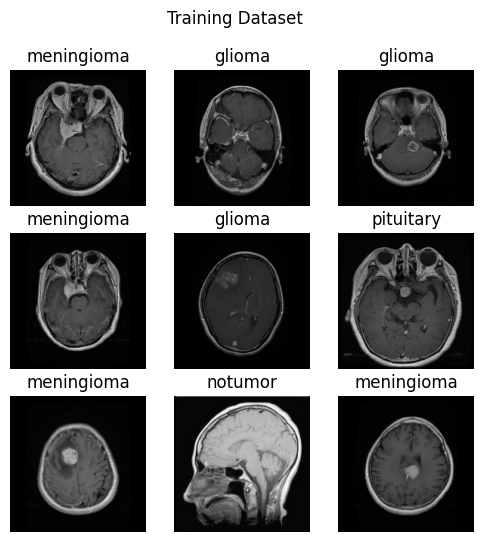

In [9]:
show_images(train_ds, "Training Dataset")

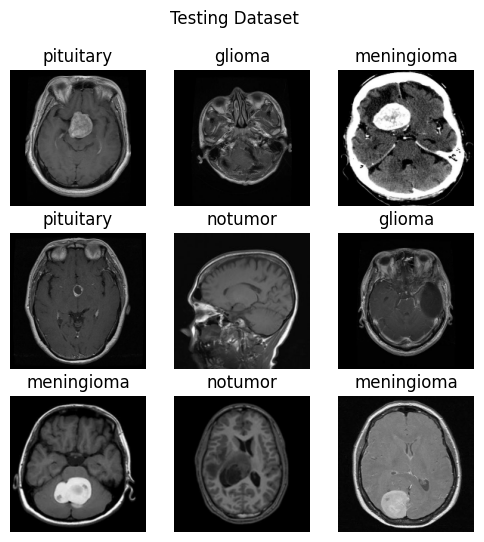

In [10]:
show_images(test_ds, 'Testing Dataset')

### **4. Preprocess the Dataset**
#### We use the Keras `ImageDataGenerator` for data augmentation and normalization.

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

Found 320 images belonging to 4 classes.


In [13]:
test_set = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

Found 80 images belonging to 4 classes.


#### **5. Build the Model**
#### We define a custom Convolutional Neural Network (CNN) architecture using Keras.

In [14]:
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,492 (25.36 MB)

 Trainable params: 6,647,492 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### **6. Compile and Train the Model**
#### We compile the CNN model using `Adam` optimizer and train it on the training dataset.

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=6,
                               restore_best_weights=True)

In [17]:
history = model.fit(training_set,
                   validation_data=test_set,
                   epochs=32,
                   callbacks=[early_stopping]
                   )

Epoch 1/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.3065 - loss: 1.6686 - val_accuracy: 0.1750 - val_loss: 1.6336
Epoch 2/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.5056 - loss: 1.0798 - val_accuracy: 0.3250 - val_loss: 2.2432
Epoch 3/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.6446 - loss: 0.8371 - val_accuracy: 0.3625 - val_loss: 2.9927
Epoch 4/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.6404 - loss: 0.8481 - val_accuracy: 0.4125 - val_loss: 2.1309
Epoch 5/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.7077 - loss: 0.7616 - val_accuracy: 0.5250 - val_loss: 3.3781
Epoch 6/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6617 - loss: 0.7336 - val_accuracy: 0.2750 - val_loss: 2.3883
Epoch 7/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.7182 - loss: 0.7259 - val_accuracy: 0.3875 - val_loss: 2.8362
Epoch 8/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.7170 - loss: 0.6911 - val_accuracy: 0.

### **7. Evaluate the Model**

In [18]:
loss, accuracy = model.evaluate(test_set)
print(f'Test Accuracy: {accuracy:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6789 - loss: 4.2034
Test Accuracy: 0.66


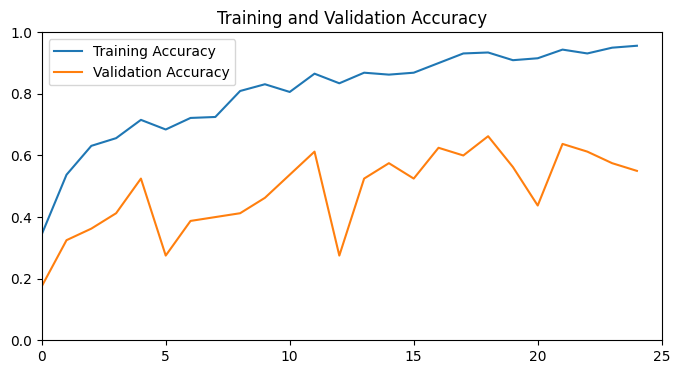

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlim(0, len(epochs))

# Set y-axis limits from 0 to 100 (or adjust based on your expected accuracy range)
plt.ylim(0, 1)
plt.legend()
plt.show()

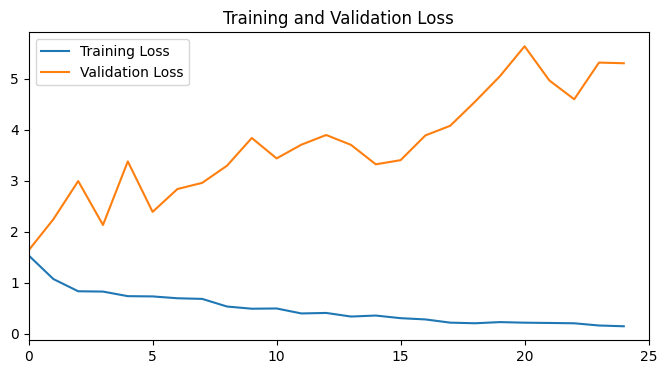

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlim(0, len(epochs))
plt.legend()
plt.show()

### **8. Save the Model**
#### Save the trained CNN model for future use.

In [28]:
model.save('/content/drive/MyDrive/brain_tumor_model.h5')

### **9. Predict on Custom Images**
#### Finally, we show how to load the saved model and make predictions on custom MRI images.

In [29]:
# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/brain_tumor_model.h5')

In [30]:
# Load and preprocess the custom image
img_path = '/content/drive/MyDrive/Tr-gl_1149.jpg'
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

# Convert the image to array
img_array = image.img_to_array(img)

# Expand dimensions to match the model's expected input shape (batch size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Rescale pixel values (same as in training)
img_array = img_array / 255.0

# Make predictions
predictions = loaded_model.predict(img_array)

# Decode the prediction (index to class label)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Class labels in the same order as used during training
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Output the predicted class
predicted_class = class_labels[predicted_class_index]
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Predicted class: glioma
